### General rules:
 * For all figures that you generate, remember to add meaningful labels to the axes, and make a legend, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.
 * Replace *Template* by your *FirstnameLastname* in the filename, or by *Lastname1Lastname2* if you work in pairs.

# BCI-IL WS 2018/2019 - Exercise Sheet #05

#### Name

In [1]:
% matplotlib inline

import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt

import bci_minitoolbox as bci

## Preparation: Load data

In [8]:
fname= 'eyes_closed_VPal.npz'
cnt, fs, clab, mnt = bci.load_data(fname)

## Exercise 1: PCA on raw data  (3 points) 
Make a scatter plot of the data with the two directions of largest variance as coordinate axes. Then, depcit the projection vectors of those two components as scalp maps (function `scalpmap` provided in the `bbci_minitoolbox`).

Text(0.5,1,'Second largest Eigenvector')

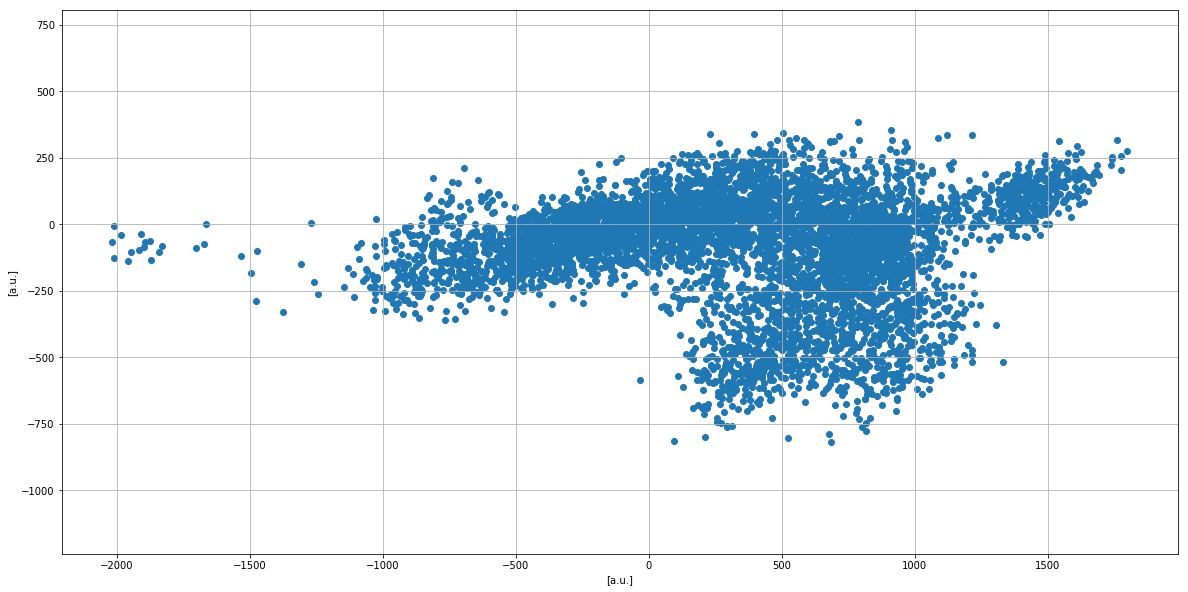

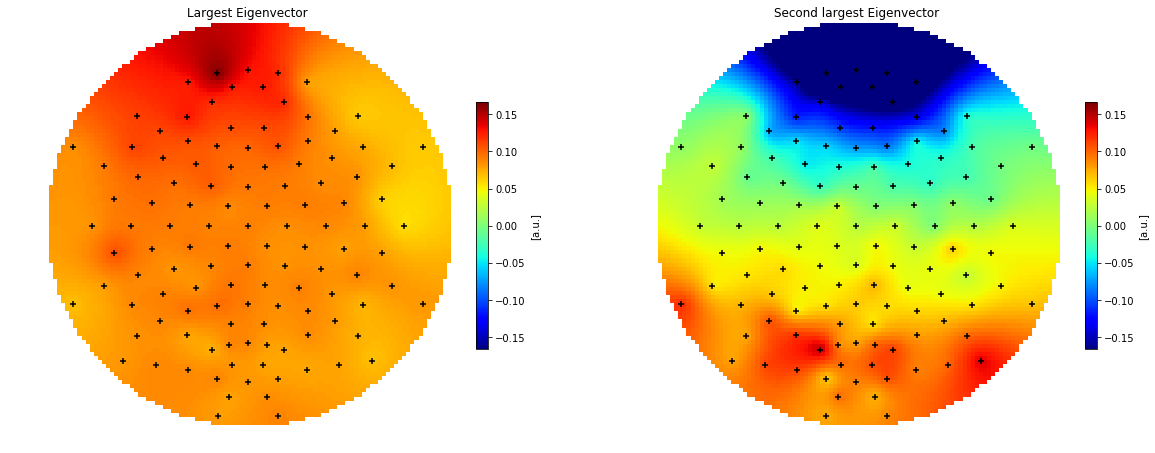

In [9]:
#Covariance Matrix
cov = np.cov(cnt)
#print(cov.shape)

#Eigenvalues and eigenvectors
eigva,eigve = np.linalg.eigh(cov)
#Extract the two largest eigenvectors and multiply them with the data
val1 = eigve[:,-1].dot(cnt)
val2 = eigve[:,-2].dot(cnt)

#Scatterplot
plt.figure(figsize = (20,10))
plt.scatter(val1,val2)
plt.axis('equal')
plt.grid()
#Labels for x and y axis?
plt.title("")
plt.xlabel("[a.u.]") 
plt.ylabel("[a.u.]") 

maxamp = abs(eigve[:,-1]).max()
plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
#with or without clim? --> maxamp = abs(eigve).max()
bci.scalpmap(mnt,eigve[:,-1], cb_label='[a.u.]', clim = (-maxamp, maxamp))
plt.title("Largest Eigenvector")

plt.subplot(2,2,2)
bci.scalpmap(mnt,eigve[:,-2], cb_label='[a.u.]', clim = (-maxamp, maxamp))
plt.title("Second largest Eigenvector")

## Exercise 2: Artifact to signal ratio with PCA  (5 points)
For this task we assume that the two components from Ex. \#01 reflect eye movements, while all other components do not contain artifacts from eye movement. If you did not succeed with Ex. \#01, chose an arbitrary component.

Determine for each channel which proportion of the overall variance is caused by eye movements and plot this information as a scalp map. Also, calculate the Signal-To-Noise ratio (SNR) in Decibel (dB).

Noise: 3285.929456854092
Signal: 3529.2717724718204
SNR: 0.6205373389411956 dB


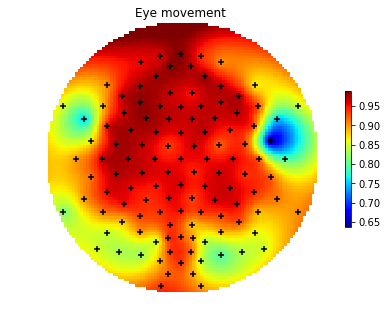

In [12]:
#Put data into source space
source = eigve.T.dot(cnt)
#print(source.shape)
#Consider only the last two rows, pad everything else
source[0:-2,:] = 0
#Normalisation
eyes = eigve.dot(source)
#Calculate Variance
eyesVar = np.var(eyes, axis=1)
cntVar = np.var(cnt, axis=1)
#print(eyesVar.shape)

plt.figure(figsize=(10,5))
#plt.subplot(1,2,1)
#plt.plot(eyes[0])
#plt.plot(cnt[0])


#plt.subplot(1,2,2)
bci.scalpmap(mnt,eyesVar/cntVar)
plt.title("Eye movement")


noise = np.average(eyesVar)
signal = np.average(cntVar)
print("Noise:", noise)
print("Signal:", signal)

db = 20*np.log10(signal/noise)
print("SNR: {} dB".format(db))

## Preparation: Load data

In [5]:
fname = 'erp_hexVPsag.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)

## Exercise 3: Artificial EEG data  (7 points)
Generate one trial of artificial, stereotypical EEG data (1000 ms, 55 channels) out of the data set of sheet #01. The
trial should contain a 'clean' target ERP composed of an N2 component (the one negatively peaking at 310 ms in the data on sheet #01) and a P3 component (the one peaking at 380 ms in the data on sheet #01). Both components should have their typical spatial distribution. To this extent, extract the corresponding scalp patterns at the peaks of the average ERPs, calculate the filters, use them to isolate the components from the average ERP and then project them back into the EEG space.
Plot the artificial EEG (the backprojected ERP) in channels PO7 and Cz and the scalp patterns correpsonding to the N2 and P3.

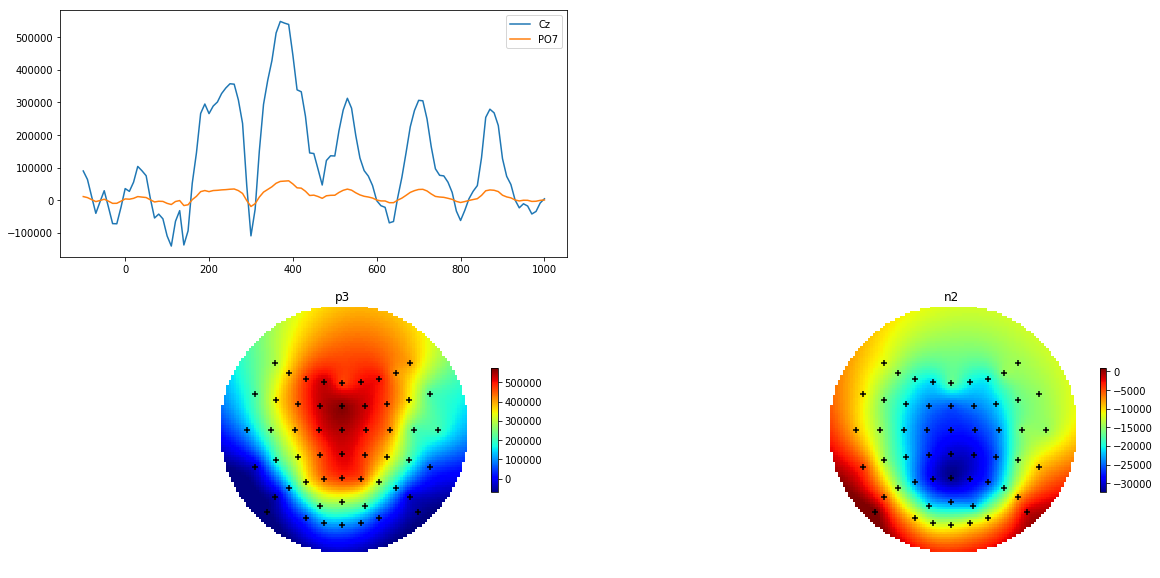

In [6]:
#Data generation
ival= [-100, 1000]
ref_ival= [-100, 0]
chans = ['Cz', 'PO7']
peakn = 310
peakp = 380
#Epochs and baseline correction
epo, epo_t = bci.makeepochs(cnt, fs, mrk_pos, ival)
epo = bci.baseline(epo, epo_t, ref_ival)

#Target data
data = epo[:,:,mrk_class==0]
data = np.mean(data,axis=2)
#print(data.shape)

#Generate time index
p3_tidx = (peakp <= epo_t) & (epo_t <= peakp)
n2_tidx = (peakn <= epo_t) & (epo_t <= peakn)

plt.figure(figsize=(20,10))
#plt.subplot(2,2,1)
#bci.scalpmap(mnt, data[p3_tidx])
#plt.subplot(2,2,2)
#bci.scalpmap(mnt,data[n2_tidx])

#Calculation of the filter A
cov = np.cov(data, rowvar = False)

W = np.vstack((data[p3_tidx],data[n2_tidx]))
W = W.T

A = cov.dot(W)
S = W.T.dot(data.T)
X = A.dot(S)

#plt.plot(epo_t,data[:,25])

chan_1 = clab.index(chans[0])
chan_2 = clab.index(chans[1])

plt.subplot(2,2,1)
plt.plot(epo_t,X.T[:,chan_1], label="Cz")
plt.plot(epo_t,X.T[:,chan_2], label="PO7")

plt.legend()
plt.subplot(2,2,3)
plt.title("p3")
bci.scalpmap(mnt, X[:,p3_tidx])
plt.subplot(2,2,4)
plt.title("n2")
bci.scalpmap(mnt, X[:,n2_tidx])